In [1]:
# imports

import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# check GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# preparing datasets
# HIDE_dataset available at https://github.com/joanshen0508/HA_deblur
# modified to have all test images in /test/test-all instead

width, height = 256, 144

DATASET_DIR = "HIDE_dataset/"

TRAIN_FNAME = DATASET_DIR+"train.txt"
# TEST_FNAME  = DATASET_DIR+"test.txt"

GT_DIR    = DATASET_DIR+"GT/"
TRAIN_DIR = DATASET_DIR+"train/"
# TEST_DIR  = DATASET_DIR+"test/test-all/"

def get_filenames(txt_path):
    with open(txt_path, "r") as f:
        filenames = [l.rstrip("\n") for l in f.readlines()]
        return filenames

train_names = get_filenames(TRAIN_FNAME)
# test_names  = get_filenames(TEST_FNAME)

In [4]:
# Create a generator (a Sequence object) because dataset can't fit in GPU memory

from tensorflow.keras.utils import Sequence
import random

BATCH_SIZE = 4

# based on:
# https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor

class TrainGenerator(Sequence):
    def __init__(self, fnames, batch_size):
        self.fnames = fnames
        self.batch_size = batch_size
        self.rng = random.Random(42)

    def __len__(self):
        return int(np.ceil(len(self.fnames) / self.batch_size))

    def __getitem__(self, idx):
        batch_names = self.fnames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x = np.empty((self.batch_size, width, height, 3), dtype=np.float32, order='C')
        batch_y = np.empty((self.batch_size, width, height, 3), dtype=np.float32, order='C')
        
        for i, fname in enumerate(batch_names):
            gt = Image.open(GT_DIR+fname)
            gt = gt.resize((width,height), resample=Image.Resampling.LANCZOS)
            gt = np.asarray(gt, dtype=np.float32)/255
            gt = gt.transpose((1, 0, 2))
            batch_y[i,...] = gt
            blur = Image.open(TRAIN_DIR+fname)
            blur = blur.resize((width,height), resample=Image.Resampling.LANCZOS)
            blur = np.asarray(blur, dtype=np.float32)/255
            blur = blur.transpose((1, 0, 2))
            batch_x[i,...] = blur
        
        return (batch_x, batch_y)
    
    def on_epoch_end(self):
        self.rng.shuffle(self.fnames)

In [5]:
# Train-test split

from sklearn.model_selection import train_test_split

f_train, f_val = train_test_split(
    train_names, test_size=0.2, random_state=42)

gen_train = TrainGenerator(f_train, BATCH_SIZE)
gen_val   = TrainGenerator(f_val,  BATCH_SIZE)

In [6]:
# Import model layers

from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from keras import activations

In [7]:
# model_4

def create_model_4():
    inp_shape = (width, height, 3)
    filter_size = 64
    
    def conv_block(inp, i):
        conv = Conv2D(filter_size * (2**i), (3, 3), padding='same')(inp)
        conv = LeakyReLU()(conv)
        conv = Conv2D(filter_size * (2**i), (3, 3), padding='same')(conv)
        conv = LeakyReLU()(conv)
        pool = MaxPooling2D((2, 2))(conv)
        return pool, conv
    
    def bottleneck(inp, i):
        conv = Conv2D(filter_size * (2**i), (3, 3), padding='same')(inp)
        conv = LeakyReLU()(conv)
        conv = Conv2D(filter_size * (2**i), (3, 3), padding='same')(conv)
        conv = LeakyReLU()(conv)
        return conv
    
    def deconv_block(inp, shortcut, i):
        deconv = Conv2DTranspose(filter_size * (2**i), (3, 3), strides=(2, 2), padding="same")(inp)
        uconv  = concatenate([shortcut, deconv])
        uconv  = Conv2D(filter_size * (2**i), (3, 3), padding="same")(uconv)
        uconv  = LeakyReLU()(uconv)
        uconv  = Conv2D(filter_size * (2**i), (3, 3), padding="same")(uconv)
        uconv  = LeakyReLU()(uconv)
        return uconv
    
    #contracting half
    inp = Input(inp_shape, batch_size=BATCH_SIZE)
    conv0, pre_pool0 = conv_block(inp,   0)
    conv1, pre_pool1 = conv_block(conv0, 1)
    conv2, pre_pool2 = conv_block(conv1, 2)
    conv3, pre_pool3 = conv_block(conv2, 3)
    mid              = bottleneck(conv3, 4)
    deconv3          = deconv_block(mid,     pre_pool3, 3)
    deconv2          = deconv_block(deconv3, pre_pool2, 2)
    deconv1          = deconv_block(deconv2, pre_pool1, 1)
    deconv0          = deconv_block(deconv1, pre_pool0, 0)
    out = Conv2D(3, (1, 1), activation='sigmoid')(deconv0)
    model = Model(inputs=[inp], outputs=[out])
    return model

In [8]:
# Mixed gradient error
# https://medium.com/analytics-vidhya/loss-functions-for-image-super-resolution-sisr-8a65644fbd85

from keras.losses import MeanAbsoluteError, MeanSquaredError

mae = MeanAbsoluteError()
mse = MeanSquaredError()

def MeanGradientError(targets, outputs, weight):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float32), axis = -1), [1, 1, 3])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, 3])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float32), axis = -1), [1, 1, 3])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, 3])
    
    outputs = tf.transpose(outputs, perm=[0, 2, 1, 3])
    targets = tf.transpose(targets, perm=[0, 2, 1, 3])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
    target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

    # compute mean gradient error
    mge = tf.math.reduce_sum(tf.math.squared_difference(output_gradients, target_gradients)) / (BATCH_SIZE * width * height)

    return mge * weight

def MixedGradientError(y_true, y_pred):
    return mae(y_true, y_pred) + MeanGradientError(y_true, y_pred, weight = 0.01)

In [9]:
# create model and load weights

MODEL_PATH = "models/model_256x144_mae_w001_CDR/"
if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

model = create_model_4()

model.load_weights(MODEL_PATH + "weights.189-0.050248_256-144.hdf5")



In [10]:
# Compile model

opt = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(optimizer=opt, loss=MixedGradientError, metrics=["mean_squared_error", "mean_absolute_error"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(4, 256, 144, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (4, 256, 144, 64)    1792        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (4, 256, 144, 64)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (4, 256, 144, 64)    36928       ['leaky_re_lu[0][0]']            
                                                                                              

                                                                                                  
 concatenate_2 (Concatenate)    (4, 128, 72, 256)    0           ['leaky_re_lu_3[0][0]',          
                                                                  'conv2d_transpose_2[0][0]']     
                                                                                                  
 conv2d_14 (Conv2D)             (4, 128, 72, 128)    295040      ['concatenate_2[0][0]']          
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (4, 128, 72, 128)    0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (4, 128, 72, 128)    147584      ['leaky_re_lu_14[0][0]']         
                                                                                                  
 leaky_re_

In [11]:
# training model

import datetime

LOG_DIR = "logs/fit/" + "model_256x144_mae_w001_CDR(" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ")"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0)
save_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH + "/weights.{epoch:03d}-{val_loss:.6f}_256-144.hdf5",
    save_weights_only=True
)

with tf.device("/GPU:0"):
    history = model.fit(gen_train,
                       epochs=250,
                       validation_data=gen_val,
                       callbacks=[tensorboard_callback, save_callback],
                       verbose=1,
                       initial_epoch=189
    )

Epoch 190/250
1280/1280 [==============================] - 2547s 2s/step - loss: 0.0538 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0348 - val_loss: 0.0512 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0327
Epoch 191/250
1280/1280 [==============================] - 2500s 2s/step - loss: 0.0526 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0338 - val_loss: 0.0509 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0326
Epoch 192/250
1280/1280 [==============================] - 2465s 2s/step - loss: 0.0523 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0335 - val_loss: 0.0504 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0321
Epoch 193/250
1280/1280 [==============================] - 2470s 2s/step - loss: 0.0519 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0332 - val_loss: 0.0511 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0331
Epoch 194/250
1280/1280 [==============================] - 2466s 2s/

1280/1280 [==============================] - 2598s 2s/step - loss: 0.0481 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0314 - val_loss: 0.0472 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0311
Epoch 226/250
1280/1280 [==============================] - 2543s 2s/step - loss: 0.0481 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0314 - val_loss: 0.0470 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0307
Epoch 227/250
1280/1280 [==============================] - 2471s 2s/step - loss: 0.0479 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0313 - val_loss: 0.0474 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0307
Epoch 228/250
1280/1280 [==============================] - 2475s 2s/step - loss: 0.0479 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0313 - val_loss: 0.0471 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0305
Epoch 229/250
1280/1280 [==============================] - 2469s 2s/step - loss: 0

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


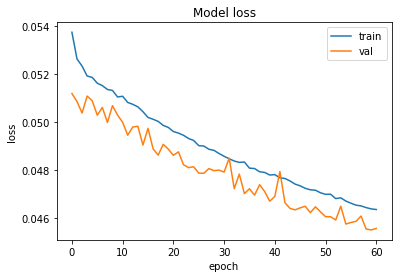

In [12]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()